In [1]:
import matplotlib.pyplot as plt

#plt.style.use('evan')

In [109]:
import numpy as np
# This just ensures some comments in dataframes below display nicely
import pandas as pd
from multihist import Hist1d, Histdd
from tqdm import tqdm
pd.options.display.max_colwidth = 100

In [110]:
import strax
export, __all__ = strax.exporter()

In [111]:
import straxen
st = straxen.contexts.strax_workshop_dali()

In [112]:
runs = st.select_runs(include_tags='spe_topbulk')

runs[['number', 'name']]

Checking data availability: 100%|██████████| 5/5 [00:03<00:00,  1.11it/s]


,number,name
30,16985,180219_1049


In [113]:
dataset = runs['name'].values[0]

In [114]:
st.data_info('raw_records')

,Field name,Data type,Comment
0,channel,int16,Channel/PMT number
1,dt,int16,Time resolution in ns
2,time,int64,Start time of the interval (ns since unix epoch)
3,length,int32,Length of the interval in samples
4,area,int32,Integral in ADC x samples
5,pulse_length,int32,Length of pulse to which the record belongs (without zero-padding)
6,record_i,int16,Fragment number in the pulse
7,baseline,float32,Baseline in ADC counts. data = int(baseline) - data_orig
8,reduction_level,uint8,Level of data reduction applied (strax.ReductionLevel enum)
9,data,"('<i2', (110,))",Waveform data in ADC counts above baseline


In [116]:
dataset

'180219_1049'

In [115]:
arr = st.get_array(dataset, 'raw_records', seconds_range=(0, 20))

Not saving raw_records while selecting a time range in the run


In [60]:
arr['data'].shape

(2067306, 600)

In [61]:
ch = 0
arr_ch = arr[arr['channel'] == ch]



In [62]:
def get_wf(arr):
    for el in arr:
        yield el['data']
        
wf_gen = get_wf(arr_ch)

In [63]:
pulse = next(wf_gen)
pulse.shape

(600,)

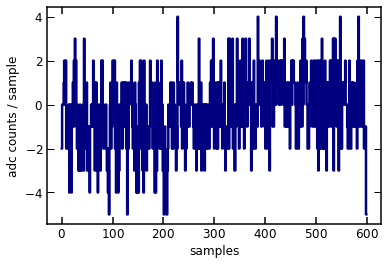

In [64]:
pulse = next(wf_gen)
plt.plot(pulse, drawstyle='steps-mid')
plt.xlabel('samples')
plt.ylabel('adc counts / sample')
plt.show()

In [65]:
from scipy.stats import norm
from scipy.optimize import curve_fit


def gaus(x, *pars):
    N, mu, sigma = pars
    return N*norm.pdf(x, loc=mu, scale=sigma)



In [66]:
channels = np.arange(248)

In [69]:
thresh = 20
off_channels = []
means = []
sigmas = []

for ch in tqdm(channels):
    arr_ch = arr[arr['channel'] == ch]
    amps = []
    for a in arr_ch:
        pulse = a['data']
        amps.append(max(pulse))
        
    # make histogram
    h = Hist1d(amps, bins=np.linspace(0,500,200))

    idx = np.where(h.bin_centers > thresh)[0]
    try:
        fit, cov = curve_fit(gaus, h.bin_centers[idx], h.histogram[idx], p0=[2000, 100, 20])
        means.append(fit[1])
        sigmas.append(fit[2])
        if fit[1] < 15:
            off_channels.append(ch)
    except:
        off_channels.append(ch)
        means.append(0)
        sigmas.append(0)

100%|██████████| 248/248 [02:16<00:00,  1.83it/s]


In [70]:
off_channels

[31, 203, 214]

Text(0.5, 0, 'SPE amplitude mean')

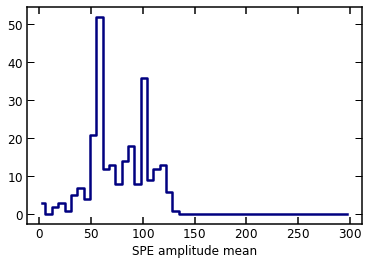

In [71]:
h = Hist1d(means, bins=np.linspace(0, 300, 50))
h.plot()
plt.xlabel('SPE amplitude mean')

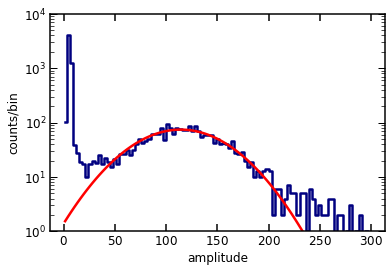

In [72]:
h = Hist1d(amps, bins=np.linspace(0,300,100))

thresh = 20
idx = np.where(h.bin_centers > thresh)[0]

fit, cov = curve_fit(gaus, h.bin_centers[idx], h.histogram[idx], p0=[2000, 100, 20])

h.plot()
plt.plot(h.bin_centers, gaus(h.bin_centers, *fit), color='red')
plt.yscale('log')
plt.ylim(1, 1e4 )
plt.xlabel('amplitude')
plt.ylabel('counts/bin')
plt.show()

In [87]:
h = Histdd(axis_names=['SPE arrival time [samples]', 'channel'], 
           bins=[np.linspace(0, 600, 100), np.linspace(0, 248, 249)])
for ch in tqdm(channels):
    arr_ch = arr[arr['channel'] == ch]
    mu, sig = means[ch], sigmas[ch]
    times = []
    for a in arr_ch:
        pulse = a['data']
        # find regions where amplitude falls in SPE mean region 
        idx = np.where((mu-0.5*sig < pulse) & (pulse < mu + sig))[0]
        times.extend(idx)
    chlist = np.ones_like(times) * ch
    
    h.add(times, chlist)
        

100%|██████████| 248/248 [00:41<00:00,  6.01it/s]


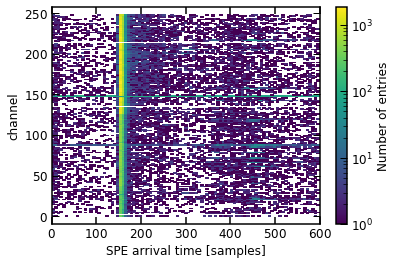

In [88]:
h.plot(log_scale=True)
plt.ylim(-10, 258)
plt.show()

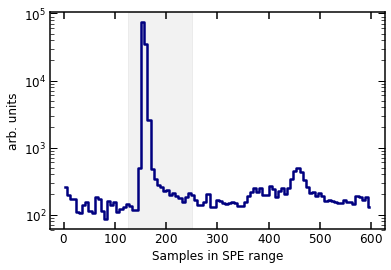

In [89]:
# select only top pmts

window = (125, 250)

hslice = h.slice(0, 148, axis=1)

hproj = hslice.projection(axis=0)

hproj.plot()
plt.yscale('log')
plt.xlabel("Samples in SPE range")
plt.ylabel('arb. units')
plt.axvspan(*window, color='grey', alpha=0.1)
plt.show()

In [138]:
def get_amplitude(raw_records, window, dtype):
    ret = []
    for r in raw_records:
        wf = r['data'][window[0]:window[1]]
        amp = wf.max()
        ret.append((amp, r['channel'], r['time']))
    ret = np.array(ret, dtype=dtype)
    return ret
        

In [139]:
@export
@strax.takes_config(
    strax.Option(
        'LED_window',
        default=(125, 250),
        help="Window (samples) where we expect signal in LED calibration"))

class LEDCal(strax.Plugin):
    __version__ = '0.0.1'

    depends_on = ('raw_records',)
    data_kind = 'led_cal'
    compressor = 'zstd'
    parallel = 'process'
    rechunk_on_save = False
    dtype = [('amplitude', np.int32, 'Amplitude in LED window'),
             ('channel', np.int16, 'Channel'),
             ('time', np.int64, 'Start time of the interval (ns since unix epoch)')
            ]

    def compute(self, raw_records):
        # Remove records from funny channels (if present)
        r = raw_records[raw_records['channel'] < 248] # hardcoded for now
        
        return get_amplitude(r, self.config['LED_window'], self.dtype)
            


In [140]:
ctext = straxen.contexts.strax_workshop_dali()
ctext.register(LEDCal)

__main__.LEDCal

In [141]:
ctext.data_info('led_cal')

,Field name,Data type,Comment
0,amplitude,int32,Amplitude in LED window
1,channel,int16,Channel
2,time,int64,Start time of the interval (ns since unix epoch)


In [142]:
df = ctext.get_df(dataset, 'led_cal')

Removing data in ./strax_data/180219_1049-led_cal-q3offybolo to overwrite


Exception in thread save_0:led_cal:
Traceback (most recent call last):
  File "/dali/lgrandi/strax/miniconda3/envs/strax/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/dali/lgrandi/strax/miniconda3/envs/strax/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "/dali/lgrandi/strax/strax/strax/storage/common.py", line 457, in save_from
    source.throw(e)
  File "/dali/lgrandi/strax/strax/strax/mailbox.py", line 323, in _read
    self.kill_from_exception(e)
  File "/dali/lgrandi/strax/strax/strax/mailbox.py", line 153, in kill_from_exception
    raise e
  File "/dali/lgrandi/strax/strax/strax/mailbox.py", line 320, in _read
    yield res
  File "/dali/lgrandi/strax/strax/strax/storage/common.py", line 441, in save_from
    new_f = self.save(data=s, chunk_i=chunk_i, executor=executor)
  File "/dali/lgrandi/strax/strax/strax/storage/common.py", line 476, in save
    chunk_info[f'{desc}_endtime'] = int(strax

ValueError: no field of name length